## Project: Prediction of Titanic survivors using machine learning
- **Source**: This
- **Date**: 10/01/24
- **Goal**: Create a basic prediction model and a feature explainer

In [1]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, 
                             f1_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)

# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data and wrangle ----------------------------------
# 1.1 Read from source and get basic info
url = ('https://gist.githubusercontent.com/teamtom/' + 
       '1af7b484954b2d4b7e981ea3e7a27f24/raw/' + 
       '114fb69dce56b4462a9c3a417e7402330616ad4f/' + 
       'titanic_full.csv')
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  746 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [3]:
# 1.2 Get a sample
display(df_raw.sample(10, random_state=2024))

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1077,3,0,Franklin Mr. Charles Charles Fardon,male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,NaN,NaN
1177,3,0,Lindell Mrs. Edvard Bengtsson Elin Gerda Persson,female,30.0,1,0,349910,15.5500,NaN,S,A,NaN,NaN
1164,1,1,Beckwith Mrs. Richard Leonard Sallie Monypeny,female,47.0,1,1,11751,52.5542,D35,S,5,NaN,New York NY
370,3,1,Murphy Miss. Katherine Kate,female,NaN,1,0,367230,15.5000,NaN,Q,16,NaN,NaN
971,3,1,Hakkarainen Mrs. Pekka Pietari Elin Matilda Dolck,female,24.0,1,0,STON/O2. 3101279,15.8500,NaN,S,15,NaN,NaN
342,3,0,Danbom Mr. Ernst Gilbert,male,34.0,1,1,347080,14.4000,NaN,S,NaN,197.0,Stanton IA
459,1,0,Hipkins Mr. William Edward,male,55.0,0,0,680,50.0000,C39,S,NaN,NaN,London / Birmingham
365,3,0,Andersson Miss. Ellis Anna Maria,female,2.0,4,2,347082,31.2750,NaN,S,NaN,NaN,Sweden Winnipeg MN
69,3,0,Wiklund Mr. Karl Johan,male,21.0,1,0,3101266,6.4958,NaN,S,NaN,NaN,NaN
232,1,1,Harper Mrs. Henry Sleeper Myna Haxtun,female,49.0,1,0,PC 17572,76.7292,D33,C,3,NaN,New York NY


### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop(['ticket','boat','body','homedest','cabin','name'], axis=1)
    .drop_duplicates()
    .assign(
        absent_age = df_raw['age'].apply(lambda x: 'yes' if pd.isna(x) else 'no'),
        survived = df_raw['survived'].map({1:'Survived', 0:'Perished'})
    )
    .rename(columns={'survived':'target'})
    .astype({'target':'category', 
             'pclass': 'category', 
             'sex': 'category',
             'embarked':'category',
             'absent_age': 'category'})
)

In [5]:
# 2.2 Create the final dataset with the target in front
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)

### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [6]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['target'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 540 to 744
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   target      891 non-null    category
 1   pclass      891 non-null    category
 2   sex         891 non-null    category
 3   age         779 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        890 non-null    float64 
 7   embarked    889 non-null    category
 8   absent_age  891 non-null    category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.8 KB


In [7]:
# 3.1 Get numerical and categorical summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
age,779.0,29.933787,15.040307,0.17,20.25,28.0,39.0000,80.0000
sibsp,891.0,0.537598,0.992947,0.00,0.00,0.0,1.0000,8.0000
parch,891.0,0.436588,0.895160,0.00,0.00,0.0,1.0000,9.0000
fare,890.0,37.414035,58.028996,0.00,8.05,15.8,34.5844,512.3292


,count,unique,top,freq
target,891,2,Perished,517
pclass,891,3,3,458
sex,891,2,male,555
embarked,889,3,S,622
absent_age,891,2,no,779


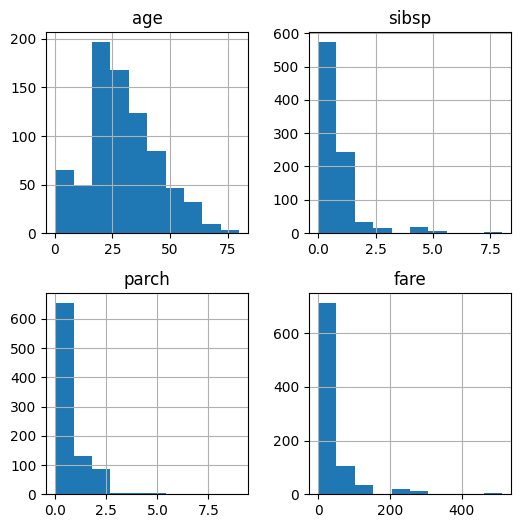

In [8]:
# 2.2 Perform univariate analysis on numerical variables
df_train.hist(figsize=(6,6))
plt.show()

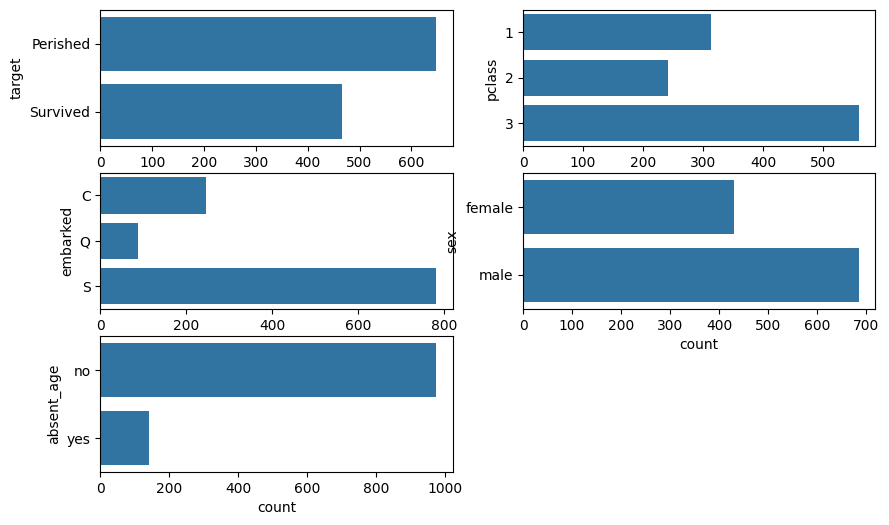

In [9]:
# 2.3 Perform univariate analysis for categorical variables
fig, ax = plt.subplots(3,2, figsize=(10,6))
sns.countplot(data=df, y='target', ax=ax[0,0])
sns.countplot(data=df, y='pclass', ax=ax[0,1])
sns.countplot(data=df, y='embarked', ax=ax[1,0])
sns.countplot(data=df, y='sex', ax=ax[1,1])
sns.countplot(data=df, y='absent_age', ax=ax[2,0])
fig.delaxes(ax[2,1])
plt.show()

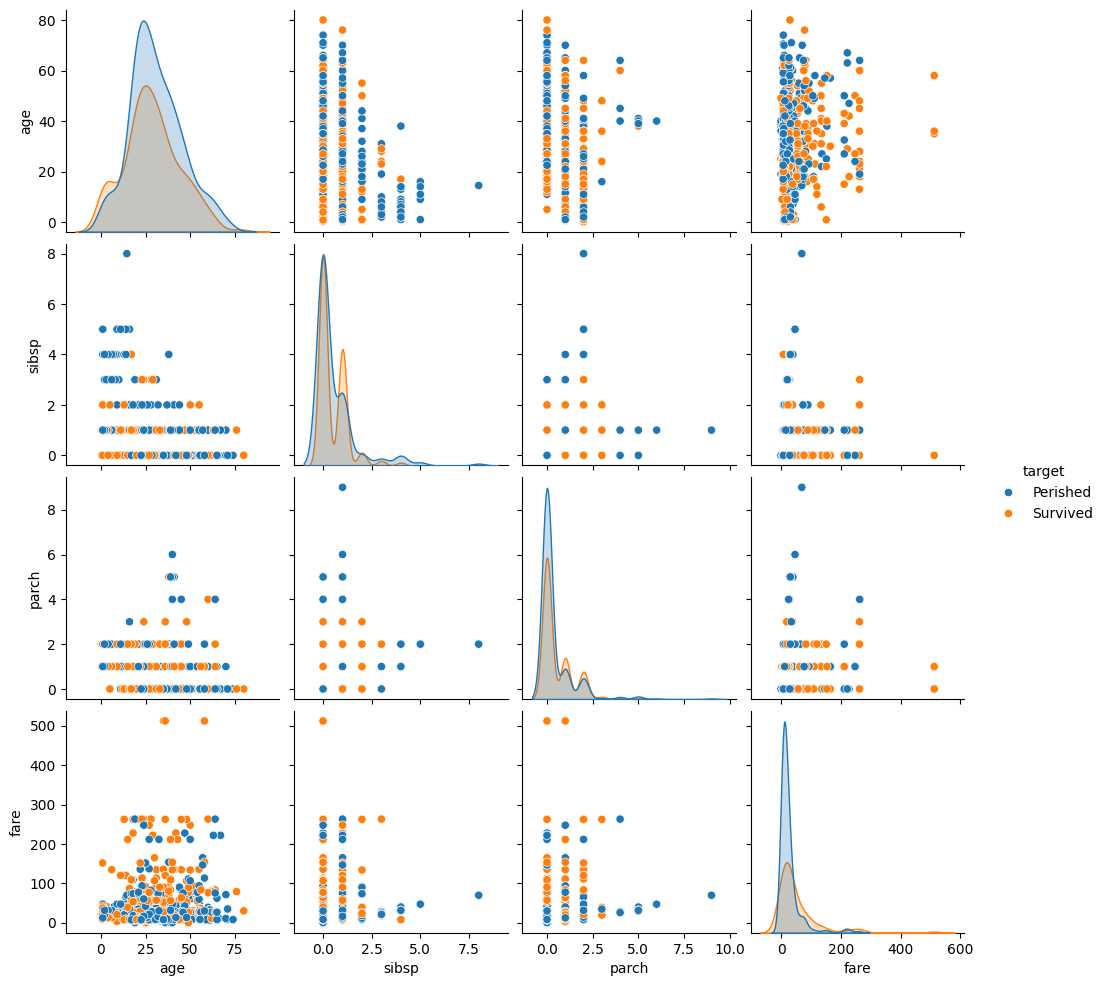

In [10]:
# 2.4 Perform bivariate analysis for numerical values, using target
sns.pairplot(data=df_train, hue='target')
plt.show()

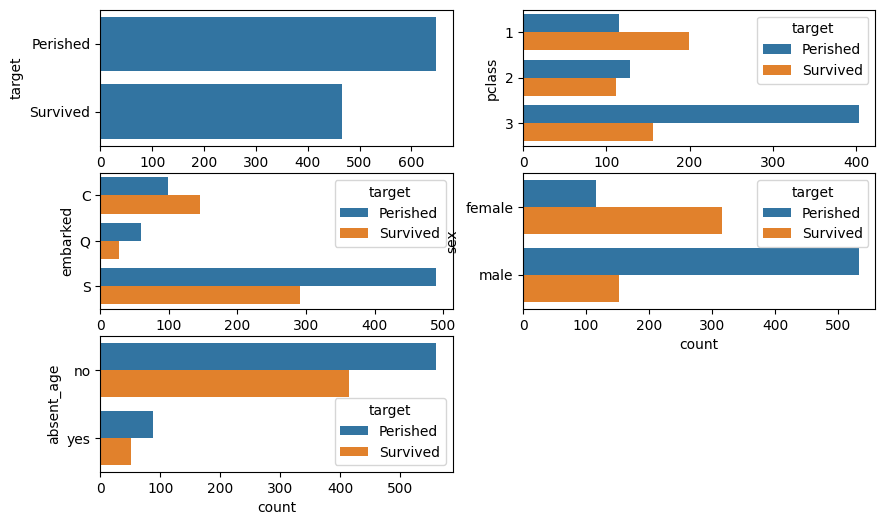

In [11]:
# 2.5 Perform bivariate analysis for categorical against target
fig, ax = plt.subplots(3,2, figsize=(10,6))
sns.countplot(data=df, y='target', ax=ax[0,0])
sns.countplot(data=df, y='pclass', ax=ax[0,1], hue='target')
sns.countplot(data=df, y='embarked', ax=ax[1,0], hue='target')
sns.countplot(data=df, y='sex', ax=ax[1,1], hue='target')
sns.countplot(data=df, y='absent_age', ax=ax[2,0], hue='target')
fig.delaxes(ax[2,1])
plt.show()

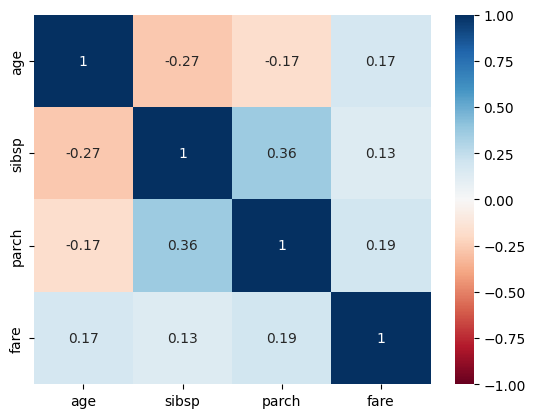

In [12]:
# 2.6 Perform correlation analysis
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [13]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [14]:
# 4.2 Encode the response 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [15]:
# 4.3 Create a pipeline for data
cat_cols = X_train.select_dtypes('category').columns
num_cols = X_train.select_dtypes('number').columns

cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('minmax', MinMaxScaler())
])

processor = ColumnTransformer(transformers=[
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [16]:
# 4.4 Create a pipeline for model training
clf_lr = Pipeline(steps=[
    ('proc',processor),
    ('lreg', LogisticRegression(class_weight='balanced'))
]
)

In [17]:
# 4.5 Train the model 
clf_lr.fit(X_train, y_train_enc)

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['pclass', 'sex', 'embarked', 'absent_age'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'sibsp', 'parch', 'fare'], dtype='object'))])),
                ('lreg', LogisticRegression(class_weight='balanced'))])

Accuracy: 0.767
F1 Score: 0.740
              precision    recall  f1-score   support

    Perished       0.84      0.75      0.79       130
    Survived       0.69      0.80      0.74        93

    accuracy                           0.77       223
   macro avg       0.76      0.77      0.76       223
weighted avg       0.78      0.77      0.77       223



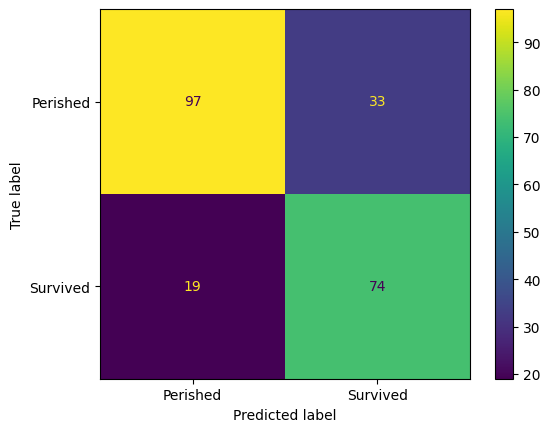

In [18]:
# 4.6 Predict on test data and get accuracy and confusion matrix
y_hat = clf_lr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_hat):.3f}')
print(f'F1 Score: {f1_score(y_test_enc, y_hat):.3f}')
print(classification_report(y_test_enc, y_hat, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_hat, display_labels=label_encoder.classes_)
plt.show()

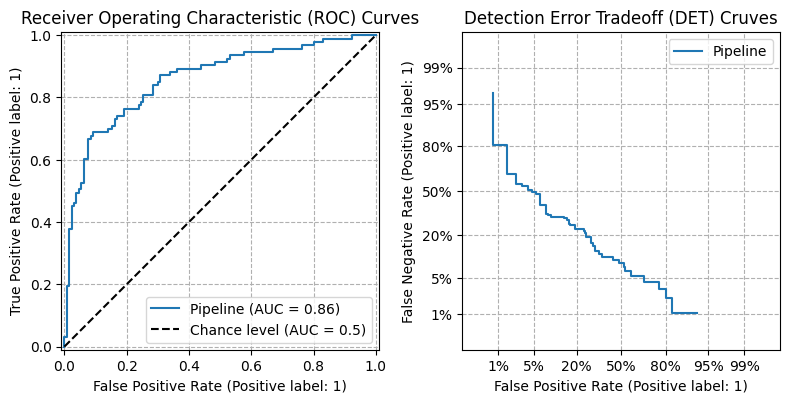

In [19]:
# 4.7 Visualize the probabilities of scores of the classifier
fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(8,8))
RocCurveDisplay.from_estimator(
    clf_lr, X_test, y_test_enc, ax=ax_roc, plot_chance_level=True
)
DetCurveDisplay.from_estimator(
    clf_lr, X_test, y_test_enc, ax=ax_det
)
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curves")
ax_det.set_title("Detection Error Tradeoff (DET) Cruves")
ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')
ax_det.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

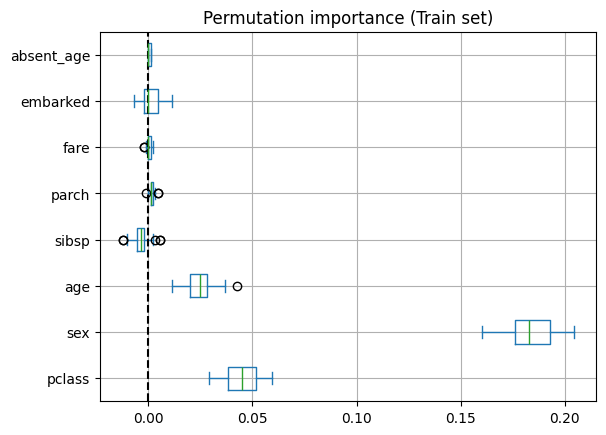

In [20]:
# 4.8 Evaluate the importance of the variables in predicting an outcome
importance = permutation_importance(clf_lr, X_train, y_train_enc, n_repeats=25, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color='k', linestyle='--')
ax.set_title('Permutation importance (Train set)')
ax.grid(True)
plt.show()

### 5. Model saving
**Objective**: Save the model and some critical information we consider necessary

In [21]:
# Step 5. Save the model for further usage
# 5.1 Create model dictionary
model_dict = {
    'model': clf_lr,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'algorithm_name': 'Logistic regression'
}

In [22]:
# 5.2 Save the model dictionary
try:
    joblib.dump(model_dict, 'titanic_model_dict.joblib')
    logger.info("Save succesful")
except Exception as e:
    logger.error(f"An error occurred: {e}")

### 6. Notes
**Objective**: Add some comments or experiments done on experimenting

In [23]:
# Note 1. You can use the pipeline to directly make the transformations
encode_train = processor.fit_transform(X_train)
df_train_tf = pd.DataFrame(encode_train, columns=processor.get_feature_names_out())
encode_test = processor.transform(X_test)
df_test_tf = pd.DataFrame(encode_test, columns=processor.get_feature_names_out())
display(df_train_tf.info())
display(df_test_tf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat__pclass_2        891 non-null    float64
 1   cat__pclass_3        891 non-null    float64
 2   cat__sex_male        891 non-null    float64
 3   cat__embarked_Q      891 non-null    float64
 4   cat__embarked_S      891 non-null    float64
 5   cat__absent_age_yes  891 non-null    float64
 6   num__age             891 non-null    float64
 7   num__sibsp           891 non-null    float64
 8   num__parch           891 non-null    float64
 9   num__fare            891 non-null    float64
dtypes: float64(10)
memory usage: 69.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cat__pclass_2        223 non-null    float64
 1   cat__pclass_3        223 non-null    float64
 2   cat__sex_male        223 non-null    float64
 3   cat__embarked_Q      223 non-null    float64
 4   cat__embarked_S      223 non-null    float64
 5   cat__absent_age_yes  223 non-null    float64
 6   num__age             223 non-null    float64
 7   num__sibsp           223 non-null    float64
 8   num__parch           223 non-null    float64
 9   num__fare            223 non-null    float64
dtypes: float64(10)
memory usage: 17.6 KB


None

In [24]:
# Note 2. You can retrieve original values of a label encoded data 
label_encoder.inverse_transform(y_train_enc)[:3]

array(['Perished', 'Perished', 'Survived'], dtype=object)